In [53]:
import plotly.graph_objects as go
from functools import cached_property
import math
import numpy as np

In [82]:
G = 6.67408e-11

class Body:
    def __init__(self, name, mass):
        self.name = name
        self.mass = mass
        
class Orbit:
    def __init__(self, primary_body, secondary_body, radius):
        # TODO: To better handle nested orbits, this should receive parent_system and child_system
        # instead of primary_body and secondary_body
        self.primary_body = primary_body
        self.secondary_body = secondary_body
        self.radius = radius
        
    @cached_property
    def period(self):
        angular_motion = math.sqrt(G * (self.primary_body.mass + self.secondary_body.mass) / (self.radius ** 3))
        return 2 * math.pi / angular_motion
    
    @cached_property
    def secondary_body_ellipse_points(self):
        return [
            self._secondary_body_position_at_anomaly(anomaly)
            for anomaly in np.linspace(0, 2 * np.pi, 500)
        ]
    
    def anomaly(self, t):
        return (t / self.period) * 2 * math.pi
        
    def secondary_body_position(self, t):
        return self._secondary_body_position_at_anomaly(self.anomaly(t))
    
    def _secondary_body_position_at_anomaly(self, anomaly):
        return [self.radius * math.cos(anomaly), self.radius * math.sin(anomaly), 0]
        
class System:
    def __init__(self, primary_body, orbit_definitions):
        self.primary_body = primary_body
        self.orbits = [
            Orbit(primary_body, secondary_body, **orbital_elements)
            for [secondary_body, orbital_elements]
            in orbit_definitions
        ]
        
    @cached_property
    def all_bodies(self):
        # TODO: Handle tree navigation for nested orbits
        return [self.primary_body, *[orbit.secondary_body for orbit in self.orbits]]
    
    @cached_property
    def all_orbits(self):
        # TODO: Handle tree navigation for nested orbits
        return self.orbits
        
    def all_positions_relative_to(self, reference_body, t):
        if reference_body != self.primary_body:
            raise notImplementedError("Can only evaluate positions relative to primary body")
        return {
            body: self._body_position_relative_to(body, reference_body, t) for body in self.all_bodies
        }
    
    def all_trajectories(self, reference_body):
        if reference_body != self.primary_body:
            raise notImplementedError("Can only evaluate trajectories relative to primary body")
        return [orbit.secondary_body_ellipse_points for orbit in self.all_orbits]
    
    def _body_position_relative_to(self, subject_body, reference_body, t):
        # TODO: Provide a referenceFrame as well as/in-lieu of a referenceBody
        if subject_body == reference_body:
            return [0, 0, 0]
        else:
            orbit = next(
                (
                    orbit
                    for orbit in self.orbits
                    if orbit.secondary_body == subject_body and orbit.primary_body == reference_body
                ),
                None
            )
            if orbit is None:
                raise NotImplementedError("Can only evaluate the position of a secondary body relative to primary")
            return orbit.secondary_body_position(t)

In [85]:
sun = Body("Sun", 100_000_000)
earth = Body("Earth", 10_000_000)
mars = Body("Mars", 8_000_000)

sun_earth_orbital_elements = { "radius": 1 }
sun_mars_orbital_elements = { "radius": 2 }

system = System(
    sun,
    [
        [earth, sun_earth_orbital_elements],
        [mars, sun_mars_orbital_elements]
    ]
)

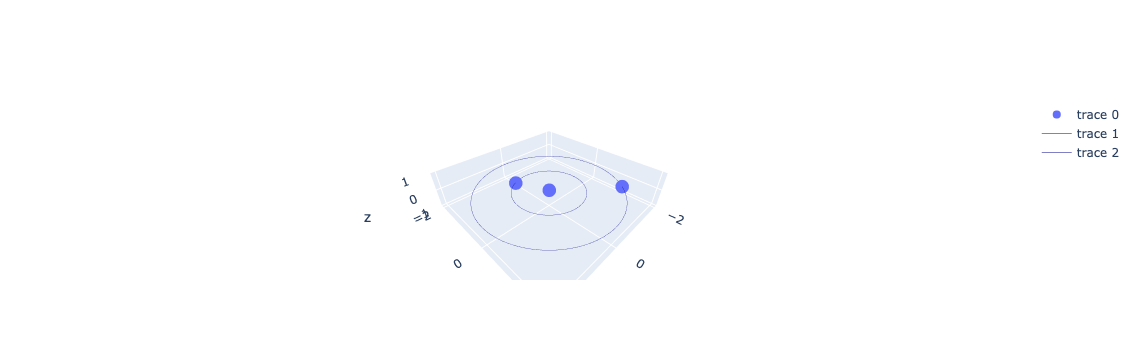

In [86]:
def trace_bodies(system, origin, t):
    body_positions = system.all_positions_relative_to(origin, t)
    x, y, z = zip(*[position for _, position in body_positions.items()])
    return go.Scatter3d(x=x, y=y, z=z, mode="markers")

def trace_orbit_trajectory(trajectory):
    x_ellipse, y_ellipse, z_ellipse = np.transpose(trajectory)
    return go.Scatter3d(
        x=x_ellipse,
        y=y_ellipse,
        z=z_ellipse,
        mode="lines",
        line=dict(color="darkblue", width=0.5),
    )

def plot_orbits(system, t):
    origin = system.primary_body
    
    trajectories = [trace_orbit_trajectory(trajectory) for trajectory in system.all_trajectories(origin)]
    bodies = trace_bodies(system, origin, t)
    
    fig = go.Figure(data=[bodies, *trajectories])
    fig.update_layout(
        scene=dict(
            xaxis=dict(nticks=4),
            yaxis=dict(nticks=4),
            zaxis=dict(nticks=4),
        )
    )
    return fig

t_val = 500
fig = plot_orbits(system, t_val)
fig.show()